# **Reading Score model**

## Objectives

- Train and evaluate a model for predicting a student's reading score

## Inputs

- outputs/datasets/filtered/reading-score-dataset.csv
- outputs/datasets/split/math/reading-test-score.csv
- outputs/datasets/split/reading/reading-train-score.csv
- outputs/datasets/split/reading/reading-test-vars.csv
- outputs/datasets/split/reading/reading-train-vars.csv

## Outputs

- A pipeline to predict a student's reading score

## Additional comments

# Change working directory

Since this notebook exists in the jupyter_notebooks directory, we need to change the current working directory from the jupyter_notebooks directory to the workspace, so that any directories created in further codes cells are added in the correct place. 

We access the current directory with the OS packages' `getcwd()` method

In [1]:
import os
current_directory = os.getcwd()
current_directory


'/workspace/Exam-Scores-Analysis/jupyter_notebooks'

We now want to set the working directory as the parent of the current working directory, jupyter_notebooks

- The `os.path.dirname()` method gets the parent directory
- The `os.chir()` method defines the new current directory
- We do this to access all of the project's files and directories, rather than those in the jupyter_notebooks directory

In [2]:
os.chdir(os.path.dirname(current_directory))
print("You set a new current directory")

You set a new current directory


To make certain of things, we now use a code cell to confirm that we have set the current working directory properly

In [3]:
current_directory = os.getcwd()
current_directory

'/workspace/Exam-Scores-Analysis'

Import packages:

In [4]:
### Standard Data Science modules:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

### SciKit Learn modules
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score

### Feature Engineering
from feature_engine.encoding import OrdinalEncoder

### Feature Scaling
from sklearn.preprocessing import StandardScaler

### Feature  Selection
from sklearn.feature_selection import SelectFromModel

### ML algorithms 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier

/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Reading Score pipeline

The reading_score variable is a continuous numerical variable, so we would normally construct and evaluate a regression model. However, with the pipeline to predict math_score, we saw that a regression model showed poor predictive performance, leading to conversion to a classification task, which showed far better performance. Therefore, we are faced with something of a dilemma - we can repeat the workflow we used in predicting math_score - regression followed by classification, or we can skip construction and evaluation of a regression model and begin with a classification model, on the basis that a regression would very likely show poor performance. 

If we look back at the correlation study notebook, we note that the math_score variable had the highest correlation scores and predictive power scores, and regression model performance was still poor. Therefore, beginning with a classification model seems like the best approach. 

First, we load the necessary dataset:

In [5]:
df_reading = pd.read_csv('outputs/datasets/filtered/reading-score-dataset.csv')
df_reading

,gender,ethnicity,parental_education,lunch_program,test_preparation_course,reading_score
0,male,group A,high school,standard,completed,67
1,female,group D,some high school,free/reduced,none,59
2,male,group E,some college,free/reduced,none,60
3,male,group B,high school,standard,none,78
4,male,group E,associate's degree,standard,completed,73
...,...,...,...,...,...,...
995,male,group C,high school,standard,none,70
996,male,group D,associate's degree,free/reduced,completed,91
997,female,group C,some high school,free/reduced,none,35
998,female,group C,some college,standard,none,74


Here, we would normally load the train and test sets, however, as they are, they are not applicable to a classification task.

We can now sort the reading_score variable of df_reading into bins. As with the math_score classification task, we will consider 3 and 4 bin approaches, using the equal frequency discretiser approach

* The classes represent the following ranges: 
{'reading_score': [-inf, 63.0, 76.0, inf]} 



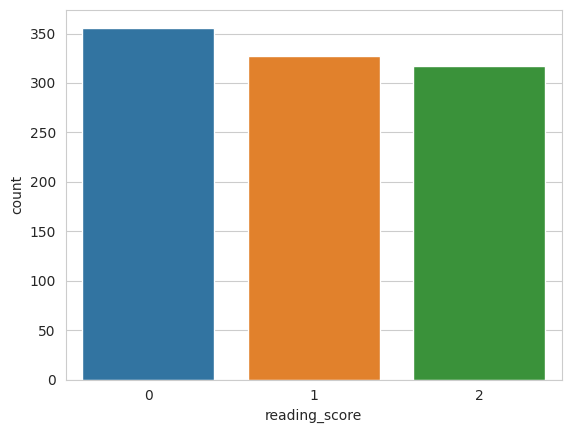

In [6]:
from feature_engine.discretisation import EqualFrequencyDiscretiser

disc_efd_3 = EqualFrequencyDiscretiser(q=3, variables=['reading_score'])
df_reading_clf_efd_3 = disc_efd_3.fit_transform(df_reading)

print(f"* The classes represent the following ranges: \n{disc_efd_3.binner_dict_} \n")
sns.countplot(data=df_reading_clf_efd_3, x='reading_score')
plt.show()

Looks to be evenly distributed. The widths of the bins are different from those assigned to the math_score. These are:
- less than 63
- 63 to 76
- Greater than 76

As with math_score, we should see what using 4 bins achieves:

* The classes represent the following ranges: 
{'reading_score': [-inf, 60.0, 70.0, 79.0, inf]} 



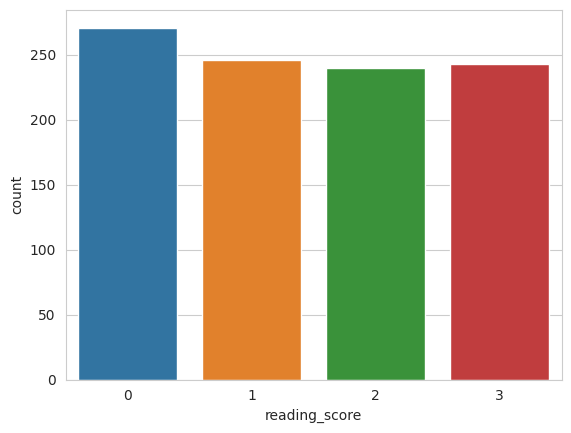

In [7]:
disc_efd_4 = EqualFrequencyDiscretiser(q=4, variables=['reading_score'])
df_reading_clf_efd_4 = disc_efd_4.fit_transform(df_reading)

print(f"* The classes represent the following ranges: \n{disc_efd_4.binner_dict_} \n")
sns.countplot(data=df_reading_clf_efd_4, x='reading_score')
plt.show()

Again, appears to be evenly distributed. As with the math_score notebook, we'll fit and evaluate pipelines with both discretised datasets, to see which performs best. 

In the math_score notebook, we briefly tried using the equal width discretiser, with extremely inbalanced results. Exploring that alternative for reading_score is probably futile. 

We'll begin with the 3-bin dataset:

In [8]:
df_reading_clf_efd_3

,gender,ethnicity,parental_education,lunch_program,test_preparation_course,reading_score
0,male,group A,high school,standard,completed,1
1,female,group D,some high school,free/reduced,none,0
2,male,group E,some college,free/reduced,none,0
3,male,group B,high school,standard,none,2
4,male,group E,associate's degree,standard,completed,1
...,...,...,...,...,...,...
995,male,group C,high school,standard,none,1
996,male,group D,associate's degree,free/reduced,completed,2
997,female,group C,some high school,free/reduced,none,0
998,female,group C,some college,standard,none,1


We'll construct the pipeline here as well:

In [9]:
def PipelineOptimization(model):
  pipeline_base = Pipeline([

      ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', 
                                                  variables = ['gender', 'ethnicity', 'parental_education', 'lunch_program', 'test_preparation_course'] ) ),
       

      ("feature_scaling", StandardScaler() ),

      ("feature_selection",  SelectFromModel(model) ),

      ("model", model ),
       
    ])

  return pipeline_base

We'll load the classification algorithms we can use:

In [10]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


Now we must split the discretised dataset:

In [11]:
reading_train_vars_3, reading_test_vars_3, reading_train_score_3, reading_test_score_3 = train_test_split(
    df_reading_clf_efd_3.drop(['reading_score'], axis=1),
    df_reading_clf_efd_3['reading_score'],
    test_size = 0.2,
    random_state = 7
)

print("* Train set:", reading_train_vars_3.shape, reading_train_score_3.shape, "\n* Test set:",  reading_test_vars_3.shape, reading_test_score_3.shape)

* Train set: (800, 5) (800,) 
* Test set: (200, 5) (200,)


Now we can define the algorithms we'll use and the default hyperparameters: 

In [12]:
models_quick_search = {
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
    "SGDClassifier": SGDClassifier(random_state=0),
    #"NaiveBayesClassifier": CategoricalNB(),
    #"SupportVectorMachine": SVC(random_state=0),
    #"KNeighborsClassifier": KNeighborsClassifier()
}

parameters_quick_search = {
    "XGBClassifier":{},
    "DecisionTreeClassifier":{},
    "RandomForestClassifier":{},
    "GradientBoostingClassifier":{},
    "ExtraTreesClassifier":{},
    "AdaBoostClassifier":{},
    "SGDClassifier": {},
   # "NaiveBayesClassifier": {},
}

During development, I tried the NaiveBayesClassifier, Support Vector Machine and KNeighborsClassifier algorithms but ran into problems

We can now define the standard HyperparameterOptimizationSearch class:

In [13]:
class HyperparameterOptimizationSearch:

    def __init__(self, models, parameters):
        self.models = models
        self.parameters = parameters
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, x, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model =  PipelineOptimization(self.models[key])

            parameters = self.parameters[key]
            grid_search = GridSearchCV(model, parameters, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
            grid_search.fit(x, y)
            self.grid_searches[key] = grid_search

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, parameters):
            summary = {
                 'estimator': key,
                 'minimum_score': min(scores),
                 'maximum_score': max(scores),
                 'mean_score': np.mean(scores),
                 'standard_deviation_score': np.std(scores),
            }
            return pd.Series({**parameters,**summary})

        rows = []
        for k in self.grid_searches:
            parameters = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                result = self.grid_searches[k].cv_results_[key]        
                scores.append(result.reshape(len(parameters), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(parameters, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'minimum_score', 'mean_score', 'maximum_score', 'standard_deviation_score']
        columns = columns + [column for column in df.columns if column not in columns]

        return df[columns], self.grid_searches

Now we can call the HyperparameterOptimizationSearch class

In [14]:
model_search_3 = HyperparameterOptimizationSearch(models=models_quick_search, parameters=parameters_quick_search)
model_search_3.fit(reading_train_vars_3, reading_train_score_3, scoring=make_scorer(recall_score, labels=[0], average=None), n_jobs=-1, cv=5)


Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.In


Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for SGDClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Now we can inspect the results:

In [15]:
reading_efd_3_model_grid_search_summary, reading_efd_3_model_grid_search_pipelines = model_search_3.score_summary(sort_by='mean_score')
reading_efd_3_model_grid_search_summary

,estimator,minimum_score,mean_score,maximum_score,standard_deviation_score
1,DecisionTreeClassifier,0.482143,0.568636,0.636364,0.059995
2,RandomForestClassifier,0.482143,0.568636,0.636364,0.059995
4,ExtraTreesClassifier,0.482143,0.568636,0.636364,0.059995
5,AdaBoostClassifier,0.381818,0.492792,0.6,0.076326
0,XGBClassifier,0.290909,0.43474,0.571429,0.090359
3,GradientBoostingClassifier,0.236364,0.413442,0.527273,0.097093
6,SGDClassifier,0.0,0.247662,0.464286,0.205859


As with the math_score notebook, the DecisionTreeClassifier has top place, but the RandomForestClassifer and ExtraTreesClassifier actually have identical results, and so are effectively tied for top place. Mean scores of 0.56 are not particularly impressive, but should suffice. To compensate for this reduced performance, we will take all 3 top performing algorithms forward for hyperparameter optimisation.

In [16]:
models_3 = {
    "DecisionTreeClassifier":DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
}
 
parameters_3 = {
    "DecisionTreeClassifier": {
                            'model__max_depth': [None, 4, 15],
                            'model__min_samples_split': [2, 50],
                            'model__min_samples_leaf': [1, 50],
                            'model__max_leaf_nodes': [None, 50],
                            },

    "RandomForestClassifier": {
                            'model__n_estimators': [100,50, 140],
                            'model__max_depth': [None,4, 15],
                            'model__min_samples_split': [2,50],
                            'model__min_samples_leaf': [1,50],
                            'model__max_leaf_nodes': [None,50],
                            },

     "ExtraTreesClassifier": {
                            'model__n_estimators': [100,50,150],
                            'model__max_depth': [None, 3, 15],
                            'model__min_samples_split': [2, 50],
                            'model__min_samples_leaf': [1,50],
                            }
}

In [17]:
parameters_search_3 = HyperparameterOptimizationSearch(models=models_3, parameters=parameters_3)
parameters_search_3.fit(reading_train_vars_3, reading_train_score_3, scoring=make_scorer(recall_score, labels=[0], average=None), n_jobs=-1, cv=5)


Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 24 candidates, totalling 120 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 72 candidates, totalling 360 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [18]:
reading_efd_3_parameters_grid_search_summary, reading_efd_3_parameters_grid_search_pipelines = parameters_search_3.score_summary(sort_by='mean_score')
reading_efd_3_parameters_grid_search_summary

,estimator,minimum_score,mean_score,maximum_score,standard_deviation_score,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators
43,RandomForestClassifier,0.553571,0.622273,0.672727,0.052267,None,50,50,2,50
46,RandomForestClassifier,0.553571,0.622273,0.672727,0.052267,None,50,50,50,50
94,RandomForestClassifier,0.553571,0.622273,0.672727,0.052267,15,50,50,50,50
67,RandomForestClassifier,0.553571,0.622273,0.672727,0.052267,4,50,50,2,50
91,RandomForestClassifier,0.553571,0.622273,0.672727,0.052267,15,50,50,2,50
...,...,...,...,...,...,...,...,...,...,...
124,ExtraTreesClassifier,0.446429,0.525195,0.625,0.05911,15,NaN,1,50,50
125,ExtraTreesClassifier,0.446429,0.525195,0.625,0.05911,15,NaN,1,50,150
101,ExtraTreesClassifier,0.446429,0.525195,0.625,0.05911,None,NaN,1,50,150
100,ExtraTreesClassifier,0.446429,0.525195,0.625,0.05911,None,NaN,1,50,50


Very interesting - it appears that optimising the hyperparameters has markedly improved performance, and even more interestingly, the RandomForestClassifier has performed best. In the condensed version of the dataframe above, we don't see the DecisionTreeClassifier, which suggests middling performance. For the sake of my own curiosity, we'll query the dataframe to see how well the DecisionTreeClassifier performed.

In [19]:
reading_efd_3_parameters_grid_search_summary.query('estimator == "DecisionTreeClassifier"').head()

,estimator,minimum_score,mean_score,maximum_score,standard_deviation_score,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators
4,DecisionTreeClassifier,0.482143,0.568636,0.636364,0.059995,None,50,1,2,NaN
0,DecisionTreeClassifier,0.482143,0.568636,0.636364,0.059995,None,None,1,2,NaN
16,DecisionTreeClassifier,0.482143,0.568636,0.636364,0.059995,15,None,1,2,NaN
20,DecisionTreeClassifier,0.482143,0.568636,0.636364,0.059995,15,50,1,2,NaN
2,DecisionTreeClassifier,0.327273,0.567857,0.75,0.179271,None,None,50,2,NaN


Interesting - it appears the DecisionTreeClassifier's performance did not improve when the hyperparameters were optimised. Therefore, we'll note the RandomForestClassifier as the best performing algorithm for the 3-bin approach.

We must now assess feature importance and generate a classification report and confusion matrix. First, we'll save the best algorithm, hyperparameters and pipeline in memory:

In [20]:
reading_efd_3_best_model = reading_efd_3_parameters_grid_search_summary.iloc[0,0]
reading_efd_3_best_model

'RandomForestClassifier'

In [21]:
reading_efd_3_best_parameters = reading_efd_3_parameters_grid_search_pipelines[reading_efd_3_best_model].best_params_
reading_efd_3_best_parameters

{'model__max_depth': None,
 'model__max_leaf_nodes': 50,
 'model__min_samples_leaf': 50,
 'model__min_samples_split': 2,
 'model__n_estimators': 50}

In [22]:
reading_efd_3_pipeline_clf = reading_efd_3_parameters_grid_search_pipelines[reading_efd_3_best_model].best_estimator_
reading_efd_3_pipeline_clf

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['gender', 'ethnicity',
                                           'parental_education',
                                           'lunch_program',
                                           'test_preparation_course'])),
                ('feature_scaling', StandardScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=RandomForestClassifier(random_state=0))),
                ('model',
                 RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=50,
                                        n_estimators=50, random_state=0))])

Now we can assess feature importance

* These are the 2 most important features in descending order. The model was trained on them: 
['ethnicity', 'parental_education']


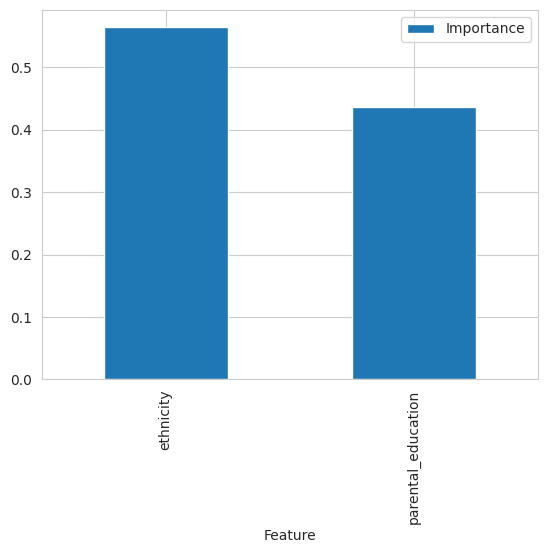

In [26]:
# after data cleaning and feat engine, the feature may space changes
data_cleaning_feat_eng_steps = 1 # how many data cleaning and feature engineering does your pipeline have?
columns_after_data_cleaning_feat_eng = (Pipeline(reading_efd_3_pipeline_clf.steps[:data_cleaning_feat_eng_steps])
                                        .transform(reading_train_vars_3)
                                        .columns)

# best_features = columns_after_data_cleaning_feat_eng
best_features_3 = columns_after_data_cleaning_feat_eng[reading_efd_3_pipeline_clf['feature_selection'].get_support()].to_list()

# create DataFrame to display feature importance
df_feature_importance_3 = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng[reading_efd_3_pipeline_clf['feature_selection'].get_support()],
          'Importance': reading_efd_3_pipeline_clf['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

reading_efd_3_best_features = df_feature_importance_3['Feature'].to_list() # reassign best features in order

# Most important features statement and plot
print(f"* These are the {len(best_features_3)} most important features in descending order. "
      f"The model was trained on them: \n{best_features_3}")

df_feature_importance_3.plot(kind='bar',x='Feature',y='Importance')
plt.show()

Interesting - as with the math_score model training, the model has identified ethnicity and parental_education as the most important feature variables.

Now for the classification report and confusion matrix:

In [27]:
from sklearn.metrics import classification_report, confusion_matrix

def confusion_matrix_and_report(x, y, pipeline, label_map):

  prediction = pipeline.predict(x)

  print('---  Confusion Matrix  ---')
  print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
        columns=[ ["Actual " + sub for sub in label_map] ], 
        index= [ ["Prediction " + sub for sub in label_map ]]
        ))
  print("\n")


  print('---  Classification Report  ---')
  print(classification_report(y, prediction, target_names=label_map),"\n")



def clf_performance(reading_train_vars, reading_train_score, reading_test_vars, reading_test_score, pipeline, label_map):
  print("#### Train Set #### \n")
  confusion_matrix_and_report(reading_train_vars_3, reading_train_score_3, pipeline, label_map)

  print("#### Test Set ####\n")
  confusion_matrix_and_report(reading_test_vars_3, reading_test_score_3, pipeline, label_map)

We'll remind ourselves of the bins:

In [28]:
disc_efd_3.binner_dict_['reading_score']

[-inf, 63.0, 76.0, inf]

Now we can define a label_map to replace the labels with more useful ones:

In [29]:
reading_efd_3_label_map = ['<63.0', '63 to 76','>76.0']
reading_efd_3_label_map

['<63.0', '63 to 76', '>76.0']

Now we can generate the classification report and confusion matrix:

In [30]:
clf_performance(reading_train_vars_3, reading_train_score_3, reading_test_vars_3, reading_test_score_3, reading_efd_3_pipeline_clf, reading_efd_3_label_map )

#### Train Set #### 

---  Confusion Matrix  ---
                    Actual <63.0 Actual 63 to 76 Actual >76.0
Prediction <63.0             186             151          126
Prediction 63 to 76           31              44           36
Prediction >76.0              61              70           95


---  Classification Report  ---
              precision    recall  f1-score   support

       <63.0       0.40      0.67      0.50       278
    63 to 76       0.40      0.17      0.23       265
       >76.0       0.42      0.37      0.39       257

    accuracy                           0.41       800
   macro avg       0.41      0.40      0.38       800
weighted avg       0.41      0.41      0.38       800
 

#### Test Set ####

---  Confusion Matrix  ---
                    Actual <63.0 Actual 63 to 76 Actual >76.0
Prediction <63.0              53              36           25
Prediction 63 to 76           12              11            9
Prediction >76.0              13              15     

Interesting - as with the math_score notebook, we see strong performance on predicting the lowest-scoring class, but weak performance when predicting the middle class and middling performance when predicting the highest-performing class. As in the math_score notebook, I think that this is acceptable, given that the intention is to identify students at risk of scoring poorly in exams. That said, this is not ideal, since we would like to be able to identify students who would score in the middle class, so that appropriate support can be offered.

We'll now try the 4 bin approach.

In [31]:
df_reading_clf_efd_4

,gender,ethnicity,parental_education,lunch_program,test_preparation_course,reading_score
0,male,group A,high school,standard,completed,1
1,female,group D,some high school,free/reduced,none,0
2,male,group E,some college,free/reduced,none,0
3,male,group B,high school,standard,none,2
4,male,group E,associate's degree,standard,completed,2
...,...,...,...,...,...,...
995,male,group C,high school,standard,none,1
996,male,group D,associate's degree,free/reduced,completed,3
997,female,group C,some high school,free/reduced,none,0
998,female,group C,some college,standard,none,2


As before, we must re-split the dataset

In [32]:
reading_train_vars_4, reading_test_vars_4, reading_train_score_4, reading_test_score_4 = train_test_split(
    df_reading_clf_efd_4.drop(['reading_score'], axis=1),
    df_reading_clf_efd_4['reading_score'],
    test_size = 0.2,
    random_state = 7
)

print("* Train set:", reading_train_vars_4.shape, reading_train_score_4.shape, "\n* Test set:",  reading_test_vars_4.shape, reading_test_score_4.shape)

* Train set: (800, 5) (800,) 
* Test set: (200, 5) (200,)


Now we determine the best algorithm to use. We already have the models_quick_search and parameters_quick_search dictionaries in memory.

In [33]:
model_search_4 = HyperparameterOptimizationSearch(models=models_quick_search, parameters=parameters_quick_search)
model_search_4.fit(reading_train_vars_4, reading_train_score_4, scoring=make_scorer(recall_score, labels=[0], average=None), n_jobs=-1, cv=5)


Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index



Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for SGDClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [34]:
reading_efd_4_model_grid_search_summary, reading_efd_4_model_grid_search_pipelines = model_search_4.score_summary(sort_by='mean_score')
reading_efd_4_model_grid_search_summary

,estimator,minimum_score,mean_score,maximum_score,standard_deviation_score
1,DecisionTreeClassifier,0.341463,0.45633,0.512195,0.060518
4,ExtraTreesClassifier,0.341463,0.45633,0.512195,0.060518
2,RandomForestClassifier,0.341463,0.422648,0.512195,0.068133
5,AdaBoostClassifier,0.365854,0.417538,0.487805,0.042376
6,SGDClassifier,0.121951,0.383856,0.658537,0.17473
3,GradientBoostingClassifier,0.170732,0.383159,0.512195,0.119521
0,XGBClassifier,0.170732,0.334262,0.47619,0.105233


As with the 3-bin approach, 2 algorithms are tied for top place - the DecisionTreeClassifier and ExtraTreeClassifier, though mean performance is significantly lower than with the 3-bin apporach. Still, optimising the hyperparameters for the 3-bin approach produced unexpectedly good results, so we will take both algorithms forward for hyperparameter optimisation.

In [35]:
models_4 = {
    "DecisionTreeClassifier":DecisionTreeClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
}
 
parameters_4 = {
    "DecisionTreeClassifier": {
                            'model__max_depth': [None, 4, 15],
                            'model__min_samples_split': [2, 50],
                            'model__min_samples_leaf': [1, 50],
                            'model__max_leaf_nodes': [None, 50],
                            },

     "ExtraTreesClassifier": {
                            'model__n_estimators': [100,50,150],
                            'model__max_depth': [None, 3, 15],
                            'model__min_samples_split': [2, 50],
                            'model__min_samples_leaf': [1,50],
                            }
}

In [36]:
parameters_search_4 = HyperparameterOptimizationSearch(models=models_4, parameters=parameters_4)
parameters_search_4.fit(reading_train_vars_4, reading_train_score_4, scoring=make_scorer(recall_score, labels=[0], average=None), n_jobs=-1, cv=5)


Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 24 candidates, totalling 120 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [37]:
reading_efd_4_parameters_grid_search_summary, reading_efd_4_parameters_grid_search_pipelines = parameters_search_4.score_summary(sort_by='mean_score')
reading_efd_4_parameters_grid_search_summary.head()

,estimator,minimum_score,mean_score,maximum_score,standard_deviation_score,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators
47,ExtraTreesClassifier,0.428571,0.534495,0.707317,0.114179,3,NaN,50,50,150
44,ExtraTreesClassifier,0.428571,0.534495,0.707317,0.114179,3,NaN,50,2,150
45,ExtraTreesClassifier,0.428571,0.519861,0.634146,0.093997,3,NaN,50,50,100
42,ExtraTreesClassifier,0.428571,0.519861,0.634146,0.093997,3,NaN,50,2,100
46,ExtraTreesClassifier,0.428571,0.514983,0.682927,0.102142,3,NaN,50,50,50


Interesting - it appears that hyperparameter optimisation has markedly improved performance, with an unusally high maximum score. However, mean score is still significantly worse than with the 3-bin approach. Therefore, we will likely proceed with the 3-bin approach

We can now assess feature importance and generate a confusion matrix and classification report

In [38]:
reading_efd_4_best_model = reading_efd_4_parameters_grid_search_summary.iloc[0,0]
reading_efd_4_best_model

'ExtraTreesClassifier'

In [39]:
reading_efd_4_best_parameters = reading_efd_4_parameters_grid_search_pipelines[reading_efd_4_best_model].best_params_
reading_efd_4_best_parameters

{'model__max_depth': 3,
 'model__min_samples_leaf': 50,
 'model__min_samples_split': 2,
 'model__n_estimators': 150}

In [40]:
reading_efd_4_pipeline_clf = reading_efd_4_parameters_grid_search_pipelines[reading_efd_4_best_model].best_estimator_
reading_efd_4_pipeline_clf

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['gender', 'ethnicity',
                                           'parental_education',
                                           'lunch_program',
                                           'test_preparation_course'])),
                ('feature_scaling', StandardScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=ExtraTreesClassifier(random_state=0))),
                ('model',
                 ExtraTreesClassifier(max_depth=3, min_samples_leaf=50,
                                      n_estimators=150, random_state=0))])

* These are the 2 most important features in descending order. The model was trained on them: 
['ethnicity', 'parental_education']


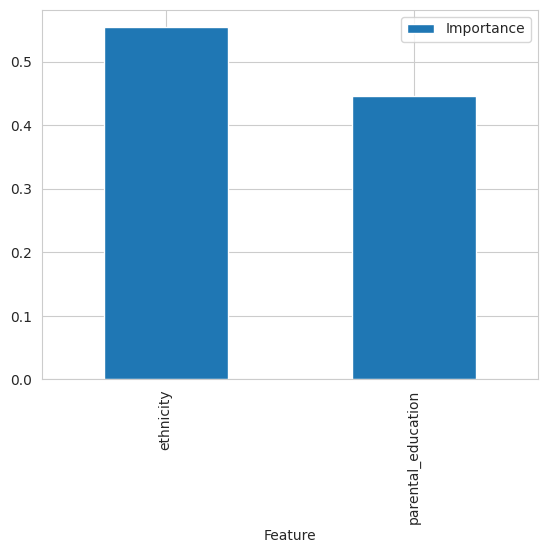

In [42]:
# after data cleaning and feat engine, the feature may space changes
data_cleaning_feat_eng_steps = 1 # how many data cleaning and feature engineering does your pipeline have?
columns_after_data_cleaning_feat_eng = (Pipeline(reading_efd_4_pipeline_clf.steps[:data_cleaning_feat_eng_steps])
                                        .transform(reading_train_vars_4)
                                        .columns)

# best_features = columns_after_data_cleaning_feat_eng
best_features_4 = columns_after_data_cleaning_feat_eng[reading_efd_4_pipeline_clf['feature_selection'].get_support()].to_list()

# create DataFrame to display feature importance
df_feature_importance_4 = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng[reading_efd_4_pipeline_clf['feature_selection'].get_support()],
          'Importance': reading_efd_4_pipeline_clf['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

reading_efd_4_best_features = df_feature_importance_4['Feature'].to_list() # reassign best features in order

# Most important features statement and plot
print(f"* These are the {len(best_features_4)} most important features in descending order. "
      f"The model was trained on them: \n{best_features_4}")

df_feature_importance_4.plot(kind='bar',x='Feature',y='Importance')
plt.show()

Interesting - the model for the 4-bin approach was trained on the ethnicity and parental_education feature variables. The same variables were used to train the 3-bin model. This is in contrast to the math_score model training, where the 3-bin model was trained on ethnicity and parental_education but the 4-bin model was trained on the lunch_program variable.

In [47]:
from sklearn.metrics import classification_report, confusion_matrix

def confusion_matrix_and_report(x, y, reading_efd_4_pipeline_clf, reading_efd_4_label_map):

  prediction = reading_efd_4_pipeline_clf.predict(x)

  print('---  Confusion Matrix  ---')
  print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
        columns=[ ["Actual " + sub for sub in reading_efd_4_label_map] ], 
        index= [ ["Prediction " + sub for sub in reading_efd_4_label_map ]]
        ))
  print("\n")


  print('---  Classification Report  ---')
  print(classification_report(y, prediction, target_names=reading_efd_4_label_map),"\n")



def clf_performance(reading_train_vars_4, reading_train_score_4, reading_test_vars_4, reading_test_score_4, reading_efd_4_pipeline_clf, reading_efd_4_label_map):
  print("#### Train Set #### \n")
  confusion_matrix_and_report(reading_train_vars_4, reading_train_score_4, reading_efd_4_pipeline_clf, reading_efd_4_label_map)

  print("#### Test Set ####\n")
  confusion_matrix_and_report(reading_test_vars_4, reading_test_score_4, reading_efd_4_pipeline_clf, reading_efd_4_label_map)

Now we need the labels of the 4 bins

In [44]:
disc_efd_4.binner_dict_['reading_score']

[-inf, 60.0, 70.0, 79.0, inf]

In [45]:
reading_efd_4_label_map = ['<60.0', '60 to 69', '70 to 79', '>79.0']
reading_efd_4_label_map

['<60.0', '60 to 69', '70 to 79', '>79.0']

In [48]:
clf_performance(reading_train_vars_4, reading_train_score_4, reading_test_vars_4, reading_test_score_4, reading_efd_4_pipeline_clf, reading_efd_4_label_map )

#### Train Set #### 

---  Confusion Matrix  ---
                    Actual <60.0 Actual 60 to 69 Actual 70 to 79 Actual >79.0
Prediction <60.0             106              75              78           41
Prediction 60 to 69           44              68              50           50
Prediction 70 to 79            0               0               0            0
Prediction >79.0              56              61              69          102


---  Classification Report  ---
              precision    recall  f1-score   support

       <60.0       0.35      0.51      0.42       206
    60 to 69       0.32      0.33      0.33       204
    70 to 79       0.00      0.00      0.00       197
       >79.0       0.35      0.53      0.42       193

    accuracy                           0.34       800
   macro avg       0.26      0.34      0.29       800
weighted avg       0.26      0.34      0.29       800
 

#### Test Set ####

---  Confusion Matrix  ---
                    Actual <60.0 Actual 60 

/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workspace/.pip-modules/lib/

Interesting - as with the math_score 4-bin approach, the model is failing to predict students who fall into the 70 to 79 class. This is not good. We could overlook this if performance on the lowest scoring class was high, but it is in fact significantly worse than the 3-bin approach's performance on the lowest scoring class. 

Therefore, we must proceed with the 3-bin approach. We can now train our final model, evaluate its performance and save the relevant files

In [57]:
def PipelineOptimization(model):
  pipeline_final = Pipeline([

      ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', 
                                                  variables = [ 'ethnicity', 'parental_education'] ) ),      

      ("feature_scaling", StandardScaler() ),

      ("model", model ),
       
    ])

  return pipeline_final

Because we have used different names for the 3-bin and 4-bin training and test sets, we do not need to resplit the data. We can simply recall those sets and filter them appropriately.

In [58]:
reading_train_score_final = reading_train_score_3
reading_test_score_final = reading_test_score_3

In [51]:
reading_train_vars_final = reading_train_vars_3.filter(reading_efd_3_best_features)
reading_train_vars_final.head()

,ethnicity,parental_education
600,group C,some college
80,group B,bachelor's degree
158,group D,associate's degree
423,group D,associate's degree
747,group A,high school


In [52]:
reading_test_vars_final = reading_test_vars_3.filter(reading_efd_3_best_features)
reading_test_vars_final.head()

,ethnicity,parental_education
778,group C,master's degree
334,group C,high school
271,group D,some high school
802,group B,some college
216,group B,associate's degree


Let's just recap the best model and hyperparameters identified during the model training and evaluation

In [53]:
reading_efd_3_best_model

'RandomForestClassifier'

In [54]:
reading_efd_3_best_parameters

{'model__max_depth': None,
 'model__max_leaf_nodes': 50,
 'model__min_samples_leaf': 50,
 'model__min_samples_split': 2,
 'model__n_estimators': 50}

We can now define these manually:

In [62]:
final_model = {'RandomForestClassifier': RandomForestClassifier(random_state=0)}

final_parameters = {'RandomForestClassifier': {
    'model__max_depth': [None],
    'model__max_leaf_nodes': [50],
    'model__min_samples_leaf': [50],
    'model__min_samples_split': [2],
    'model__n_estimators': [50]
    }}

In [63]:
search_final = HyperparameterOptimizationSearch(models=final_model, parameters=final_parameters)
search_final.fit(reading_train_vars_final, reading_train_score_final,
           scoring = make_scorer(recall_score, labels=[0], average=None),
           n_jobs=-1,cv=5)


Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [65]:
grid_search_summary_reading_final, grid_search_pipelines_reading_final = search_final.score_summary(sort_by='mean_score')
grid_search_summary_reading_final

,estimator,minimum_score,mean_score,maximum_score,standard_deviation_score,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators
0,RandomForestClassifier,0.553571,0.622273,0.672727,0.052267,None,50,50,2,50


In [66]:
final_reading_model = grid_search_summary_reading_final.iloc[0,0]
final_reading_model

'RandomForestClassifier'

In [68]:
pipeline_clf_reading_final = grid_search_pipelines_reading_final[final_reading_model].best_estimator_
pipeline_clf_reading_final

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['ethnicity', 'parental_education'])),
                ('feature_scaling', StandardScaler()),
                ('model',
                 RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=50,
                                        n_estimators=50, random_state=0))])

* These are the 2 most important features in descending order. The model was trained on them: 
['ethnicity', 'parental_education']


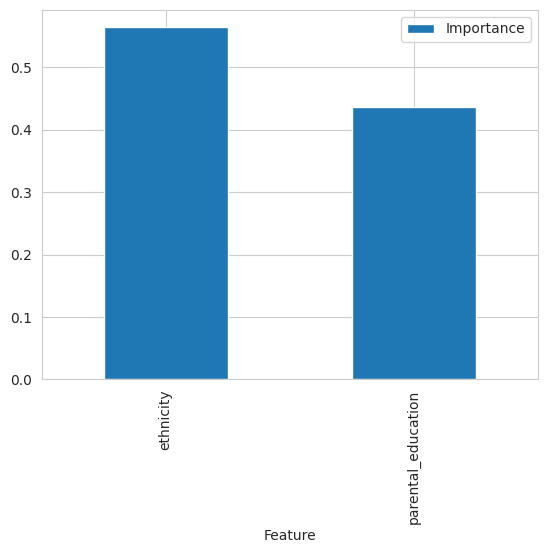

In [69]:
# after data cleaning and feat engine, the feature may space changes
data_cleaning_feat_eng_steps = 1 # how many data cleaning and feature engineering does your pipeline have?
columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_clf_reading_final.steps[:data_cleaning_feat_eng_steps])
                                        .transform(reading_train_vars_final)
                                        .columns)

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng,
          'Importance': pipeline_clf_reading_final['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

best_features_final = df_feature_importance['Feature'].to_list() # reassign best features in order

# Most important features statement and plot
print(f"* These are the {len(best_features_final)} most important features in descending order. "
      f"The model was trained on them: \n{best_features_final}")

df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

In [70]:
clf_performance(reading_train_vars_final, reading_train_score_final, reading_test_vars_final, reading_test_score_final, pipeline_clf_reading_final, reading_efd_3_label_map )

#### Train Set #### 

---  Confusion Matrix  ---
                    Actual <63.0 Actual 63 to 76 Actual >76.0
Prediction <63.0             186             151          126
Prediction 63 to 76           31              44           36
Prediction >76.0              61              70           95


---  Classification Report  ---
              precision    recall  f1-score   support

       <63.0       0.40      0.67      0.50       278
    63 to 76       0.40      0.17      0.23       265
       >76.0       0.42      0.37      0.39       257

    accuracy                           0.41       800
   macro avg       0.41      0.40      0.38       800
weighted avg       0.41      0.41      0.38       800
 

#### Test Set ####

---  Confusion Matrix  ---
                    Actual <63.0 Actual 63 to 76 Actual >76.0
Prediction <63.0              53              36           25
Prediction 63 to 76           12              11            9
Prediction >76.0              13              15     

Excellent - performance is unchanged, proving that the variables identified as unimportant have no bearing on the predictive ability of the pipeline.

We can now save the files

In [71]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_reading/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

In [72]:
! rm outputs/ml_pipeline/predict_reading/v1/reading-train-vars.csv
reading_train_vars_final.to_csv(f'{file_path}/reading-train-vars.csv', index=False)
print(f'reading-train-vars.csv created in {file_path}')

! rm outputs/ml_pipeline/predict_reading/v1/reading-train-score.csv
reading_train_score_final.to_csv(f'{file_path}/reading-train-score.csv', index=False)
print(f'reading-train-score.csv created in {file_path}')

! rm outputs/ml_pipeline/predict_reading/v1/reading-test-vars.csv
reading_test_vars_final.to_csv(f'{file_path}/reading-test-vars.csv', index=False)
print(f'reading-test-vars.csv created in {file_path}')

! rm outputs/ml_pipeline/predict_reading/v1/reading-test-score.csv
reading_test_score_final.to_csv(f'{file_path}/reading-test-score.csv', index=False)
print(f'reading-test-score.csv created in {file_path}')

rm: cannot remove 'outputs/ml_pipeline/predict_reading/v1/reading-train-vars.csv': No such file or directory
reading-train-vars.csv created in outputs/ml_pipeline/predict_reading/v1
rm: cannot remove 'outputs/ml_pipeline/predict_reading/v1/reading-train-score.csv': No such file or directory
reading-train-score.csv created in outputs/ml_pipeline/predict_reading/v1
rm: cannot remove 'outputs/ml_pipeline/predict_reading/v1/reading-test-vars.csv': No such file or directory
reading-test-vars.csv created in outputs/ml_pipeline/predict_reading/v1
rm: cannot remove 'outputs/ml_pipeline/predict_reading/v1/reading-test-score.csv': No such file or directory
reading-test-score.csv created in outputs/ml_pipeline/predict_reading/v1


In [74]:
! rm outputs/ml_pipeline/predict_reading/v1/pipeline-clf-reading.pkl

joblib.dump(value=pipeline_clf_reading_final, filename=f"{file_path}/pipeline-clf-reading.pkl")
print(f'pipeline-clf-reading.pkl created in {file_path}')

rm: cannot remove 'outputs/ml_pipeline/predict_reading/v1/pipeline-clf-reading.pkl': No such file or directory
pipeline-clf-reading.pkl created in outputs/ml_pipeline/predict_reading/v1


In [75]:
! rm outputs/ml_pipeline/predict_reading/v1/label-map-reading.pkl

joblib.dump(value=reading_efd_3_label_map, filename=f"{file_path}/label-map-reading.pkl")
print(f'label-map-reading created in {file_path}')

rm: cannot remove 'outputs/ml_pipeline/predict_reading/v1/label-map-reading.pkl': No such file or directory
label-map-reading created in outputs/ml_pipeline/predict_reading/v1


rm: cannot remove 'outputs/ml_pipeline/predict_reading/v1/feature-importance-plot-reading.png': No such file or directory


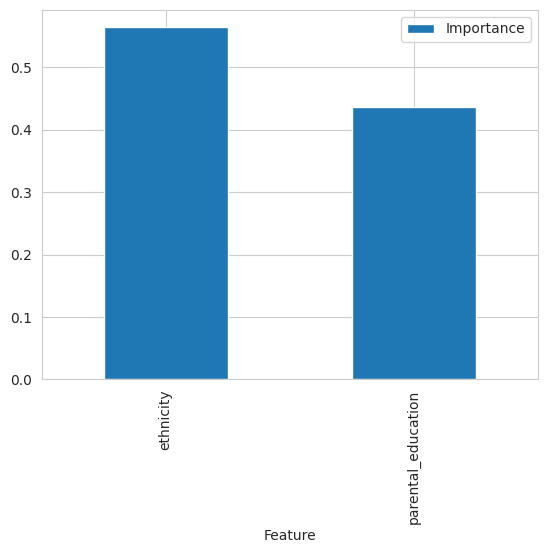

In [76]:
! rm outputs/ml_pipeline/predict_reading/v1/feature-importance-plot-reading.png

df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/feature-importance-plot-reading.png', bbox_inches='tight')

Excellent - we have now trained a model for predicting a student's reading score. After requiring a classification task for the math_score prediction task, we went straight for a classification method for the reading_score prediction task, reasoning that a regression model would offer poor performance.